#Introducción

En todo proyecto relacionado a ciencia de datos e I.A. los datos debe pasar por un proceso previo a la generación y entrenamiento de los modelos.

El primer paso es comprender los datos mediante el análisis exploratorio de datos (EDA), esto nos ofrece un panorama general del problema al cual nos enfrentaremos y nos ayudará a escoger las herramientas y/o técnicas más adecuadas para abordarlo; permitiendo identificar problemas como valores atípicos que existen en nuestro conjunto de datos.El análisis ya mencionado implica el uso de gráficos y visualizaciones para explorar y analizar un conjunto de datos. El objetivo es explorar, investigar y aprender.

Es necesario limpiar estos problemas antes de comenzar cualquier análisis porque si nuestros datos arrojan basura, también lo hará nuestro análisis. 

Las cosas se complican un poco más cuando tratamos con conjuntos de datos que tienen propiedades ocultas como conjuntos de datos de series de tiempo. Los conjuntos de datos de series de tiempo son un tipo especial de datos que se ordenan cronológicamente y necesitan atención especial para manejar sus elementos intrínsecos como la tendencia y la estacionalidad.


#Elementos de datos de series temporales

## Tendencia

Se denomina tendencia de una serie temporal a su comportamiento o movimiento a largo plazo. Por ejemplo, la gráfica adjunta muestra la serie de ventas de turismos en Castilla y León desde enero de 1980. La línea recta podría representar la tendencia (creciente). La pendiente es de 10.4, lo que indica que "tendencialmente" cada mes se venden 10.4 turismos más que en el anterior.

Esa recta se ha construido como la recta de regresión de la nube de puntos que representa la serie.

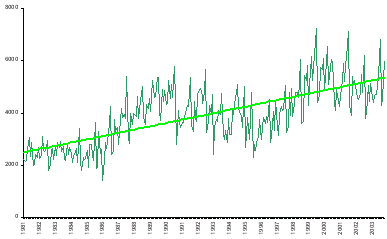

##Componente cíclica

Esta componente refleja comportamientos recurrentes.

Con frecuencia los ciclos económicos resultan de la superposición o yuxtaposición de distintos efectos, con periodos diferentes, más cortos o más largos.

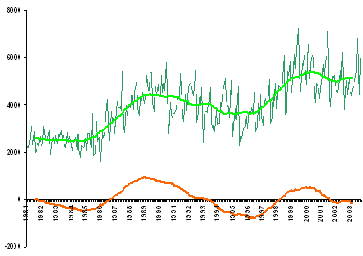

La figura de arriba ilustra esta definición con la representación de la anterior serie de ventas de turismos, junto con la componente cíclica (de color naranja). Como decíamos, a veces no se separa de la tendencia. A la componente se le denomina entonces la "ciclo-tendencia". En esa figura se muestra (en color verde y con trazo grueso) la ciclo-tendencia de la serie de ventas de turismos.



##Componente estacional

Muchas series económicas presentan oscilaciones regulares en el mismo mes de cada año, y con unas pautas que se presentan, sin repetirse exactamente, todos los años. Son las llamadas "variaciones estacionales", y se deben básicamente a causas climatológicas, vacacionales o fiscales.

La figura adyacente muestra en un gráfico especial, de los denominados de "telaraña" las matriculaciones de turismos en Castilla y León durante los años 1999 a 2003. Cada radio es un mes (1 para enero, 2 para febrero, etc.) y puede observarse ciertas pautas. Por ejemplo, que enero, agosto y septiembre son meses con pocas matriculaciones relativas, mientras que julio y junio son meses de elevados valores, en comparación con la tendencia. No representamos más años en esta gráfica, pero el efecto no es muy diferente si lo hacemos.

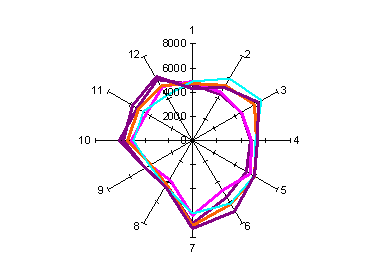

#Importar librerias

In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf
import random
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.stattools import kpss
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data

En este ejemplo se utiliza un conjunto de datos de series de tiempo;
El tiempo registrado por el Instituto Max Planck de Biogeoquímica.

##Cargar los datos

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

##Revisar por primer vez los datos

In [3]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


##Definir granularidad

Los datos que tenemos están con una resolución de 10min. pero para este ejemplo usaremos los datos por hora

In [4]:
#  [inicio:fin:no.de pasos];
#iniciamos en 5 (primer hora)
#finalizamos hasta terminar de recorrer todos nuestros datos
#los pasos son de 6 elementos (porque cada 6 hacen una hora)
df = df[5::6]

##Revisar por 2 vez los datos

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Para poder tratar los datos, es necesario quitar la columna Date Time y guardarla en otro vector independiente

In [6]:
#df.pop() -> elimina la columna Date Time
#pd.to_datetime -> convierte un conjunto de datos a valores de fecha
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

## Revisión numero 3 de los datos

In [7]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [8]:
date_time.head()

5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
Name: Date Time, dtype: datetime64[ns]

## Visualización de los datos

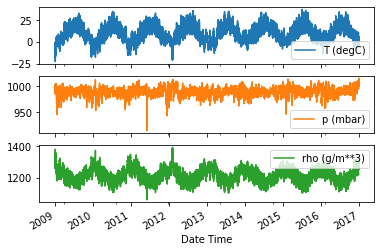

In [9]:
#Todo el conjunto
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)



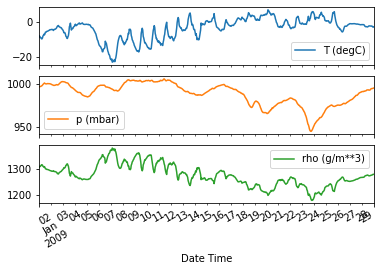

In [10]:
#Del primer mes
plot_features = df[plot_cols][:24*28]
plot_features.index = date_time[:24*28]
_ = plot_features.plot(subplots=True)

#Gráficos de autocorrelación y autocorrelación parcial

Los gráficos de autocorrelación (ACF) y de autocorrelación parcial (PACF) se utilizan mucho para determinar la estacionariedad y los parámetros del modelo de series de tiempo. Estos gráficos resumen gráficamente la fuerza de una relación con una observación en una serie de tiempo con observaciones en pasos de tiempo anteriores.

Para las gráficas ACF, calculamos la correlación para las observaciones de series de tiempo con observaciones con pasos de tiempo anteriores, llamados rezagos. El gráfico PACF es un resumen de la relación entre una observación en una serie de tiempo con observaciones en pasos de tiempo anteriores con las relaciones de observaciones intermedias eliminadas. Dichos gráficos de tiempo para un proceso estacionario comenzarán a tener valores estadísticamente insignificantes dentro de los primeros retrasos.

##Autocorrelación de la variable p (mbar)

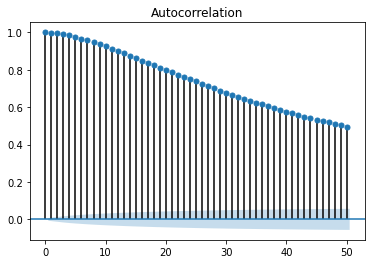

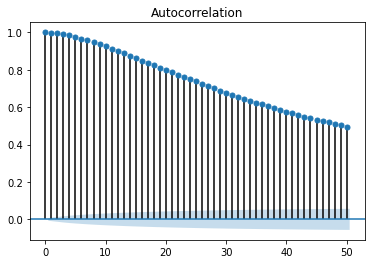

In [11]:
plot_acf(df['p (mbar)'], lags=50)

Se puede observar que el punto de interés tiene una correlación muy fuerte con el anterior, pero a través del tiempo está correlación se discipa como se ve en los gráficos de abajo

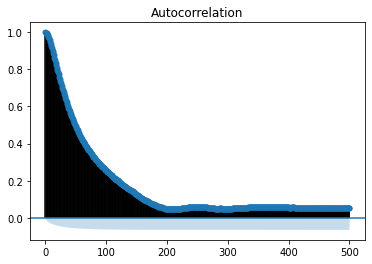

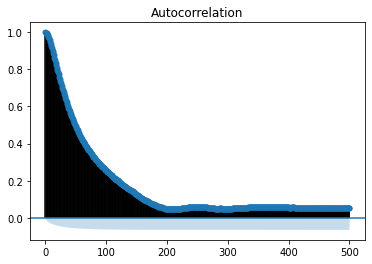

In [12]:
plot_acf(df['p (mbar)'], lags=500)

##Autocorrelación de la variable T (degC)

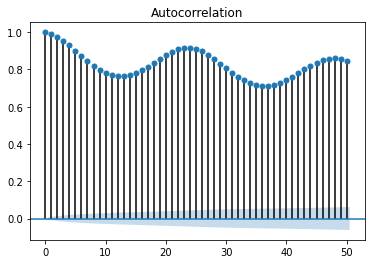

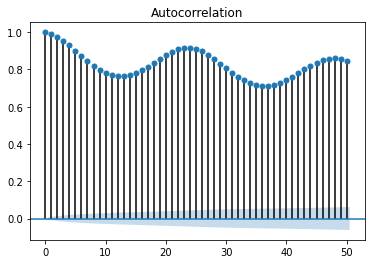

In [13]:
plot_acf(df['T (degC)'], lags=50)

En este caso la autocorrelación se presenta a lo largo del tiempo y en cierto modo se mantiene

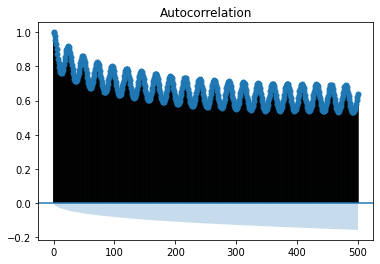

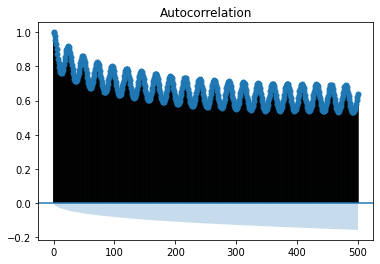

In [14]:
plot_acf(df['T (degC)'], lags=500)

##Autocorrelación de datos generados aleatoriamente

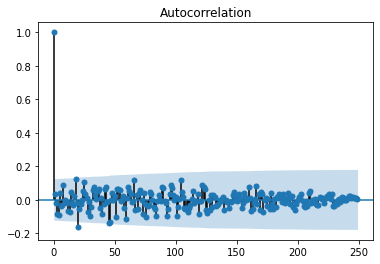

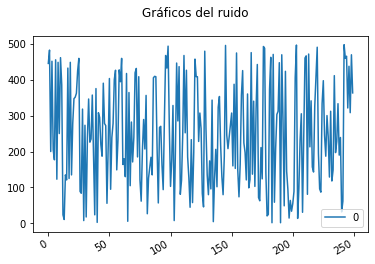

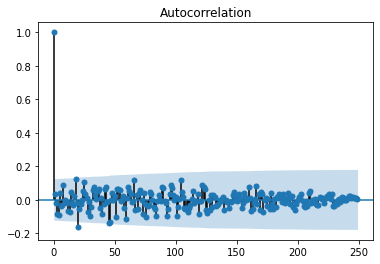

In [15]:
aleatorio=np.ones((250))
for i,_ in enumerate(aleatorio):
  aleatorio[i]=random.randint(0,500)
aleatorio2=pd.DataFrame(aleatorio)
_ = aleatorio2.plot(subplots=True,title='Gráficos del ruido')
plot_acf(aleatorio, lags=249)

En este caso se observa que la correlación más grande corresponde al punto de interés con sigo mismo, de alli en fuera no existe correlación con ningun otro arriba del .2

# Pruebas de raíz unitaria (estacionaridad)

Una serie es estacionaria cuando es estable a lo largo del tiempo, es decir,
cuando la media y varianza son constantes en el tiempo. Esto se refleja gráficamente en que los
valores de la serie tienden a oscilar alrededor de una media constante y la variabilidad con
respecto a esa media también permanece constante en el tiempo.

##Dickey-Fuller Aumentada


In [16]:
print ('Prueba ADF:', ADF(df['T (degC)']))
# Los valores de retorno son adf, pvalue, usedlag, nobs, valores críticos, icbest, regresults, restore

Prueba ADF: (-8.563580741044131, 8.564826672533807e-14, 62, 70028, {'1%': -3.4304433846421474, '5%': -2.861581274354111, '10%': -2.566791968928322}, 153621.76794793358)


### Si   pvalue  <  valorescriticos   -> no hay raíz unitaria (ESTACIONARIO)

A partir de los resultados devueltos, tenemos p = 8.564826672533958e-14 
y tomamos la probabilidad de equivocarnos del 1% que corresponde a -3.4304.

por lo tanto p>V.C. y la secuencia se considera NO estacionaria.


Nota: recordar que hay muchas variaciones de DF las cuales toman en cuenta si hay tendencia o constancia en las series temporales, en este caso se ve ADF a manera de ejemplo




##Prueba KPSS

In [17]:
print ('Prueba kpss:', kpss(df['T (degC)']))
# Los valores de retorno son kpss stat, pvalue, usedlag, valores críticos, restore

Prueba kpss: (1.9759139829508878, 0.01, 62, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Hipotesis:

H0 es: la secuencia es estacionaria

rechazar H0 se refiere a la ocurrencia de "pvalue > valores críticos"

Usaremos la probabilidad de equivocarse de 1%,por lo tanto

p = 0.01< 0.739;

La secuencia original es una secuencia NO estacionaria.

#EDA

##1) Examinar los campos

In [18]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Para averiguar el numero total de columnas y el tipo de datos guarado usamos la función .info()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70091 entries, 5 to 420545
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         70091 non-null  float64
 1   T (degC)         70091 non-null  float64
 2   Tpot (K)         70091 non-null  float64
 3   Tdew (degC)      70091 non-null  float64
 4   rh (%)           70091 non-null  float64
 5   VPmax (mbar)     70091 non-null  float64
 6   VPact (mbar)     70091 non-null  float64
 7   VPdef (mbar)     70091 non-null  float64
 8   sh (g/kg)        70091 non-null  float64
 9   H2OC (mmol/mol)  70091 non-null  float64
 10  rho (g/m**3)     70091 non-null  float64
 11  wv (m/s)         70091 non-null  float64
 12  max. wv (m/s)    70091 non-null  float64
 13  wd (deg)         70091 non-null  float64
dtypes: float64(14)
memory usage: 7.5 MB


Posteriormente obtenemos las métricas más usadas en análisis estadisticos

(de manera personal me gusta ver la descripcion transpuesta)

In [20]:
np.transpose(df.describe())

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Aquí encontramos algo interesante: ¿Es posible que tener velocidades de viento (wv (m/s)) negativas?

La respuesta es no, la velocidad del viento se define va desde [0,inf); por lo tanto debemos corregir ese dato que probablemente sea erroneo

In [21]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

In [22]:
np.transpose(df.describe())

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Como se puede apreciar esos datos erroneos afectaban demasiado los datos descriptivos, antes de corregirlso contabamos con una desviacion > 60 y ahora la desviacion es < 2.4

## Detección de valores atipicos

Una manera rápida de descubrir valores a tipicos en nuestro conjunto de datos es observar la diferencia entra el valor minimo y el percentil 25% y el maximo vs 75%.

para entender esto, tomaremos como ejemplo los valores de la velocidad del viento; 

observamos que el velor del 75% es de 2.860	y el máximo es de 14.01. En este caso hablamos de valores atipicos, que ocurren tal vez una vez cada 1000 muestras, pero que sea a tipico no sirgnifica que no sea útil, todo depende del tipo de problema que afrontemos.

para el análisis de estos valores lo primero que debemos hacer es graficar el histograma y así conocer que tipo de modelo se ajusta al mismo.

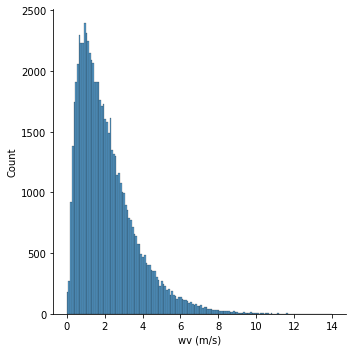

In [23]:
sns.displot(df['wv (m/s)'])

a simple vista y sin entrar en mayor análisis, la distribución se comporta como una tipo gamma.

y al parecer apartir del 8 empezamos a tener valores atipicos que valdría la pena analizar si realmente aportan información al sistema o simplemente es información tipo ruido para el mismo.

Una forma rápida para descartar información tipo ruido es hacer diagrmas de caja los cuales son una buena herramienta para identificar estos valores.

Una gráfica de caja y bigotes generalmente se usa para resumir la distribución de una muestra de datos siendo una alternativa a los histogramas.
El eje x se utiliza para representar la muestra de datos, donde se pueden dibujar varios diagramas de caja uno al lado del otro si se desea.
El eje y representa los valores de observación. Se dibuja un cuadro para resumir el 50% medio del conjunto de datos que comienza en la observación en el percentil 25 y termina en el percentil 75. La mediana, o percentil 50, se dibuja con una línea. Un valor llamado rango intercuartil, o IQR, se calcula como 1.5 * la diferencia entre los percentiles 75 y 25. Las líneas llamadas bigotes se dibujan extendiéndose desde ambos extremos de la caja con la longitud del IQR para demostrar el rango esperado de valores sensibles en la distribución. Las observaciones fuera de los bigotes pueden ser valores atípicos y se dibujan con pequeños círculos.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


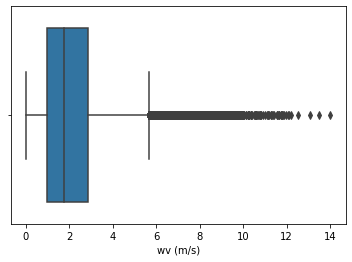

In [24]:
sns.boxplot(df['wv (m/s)'])


{'boxes': [<matplotlib.lines.Line2D at 0x7f9a4e1934d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f9a4e1476d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9a4d51cb90>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f9a4d51c8d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f9a4d53f990>,
  <matplotlib.lines.Line2D at 0x7f9a4e147e10>]}

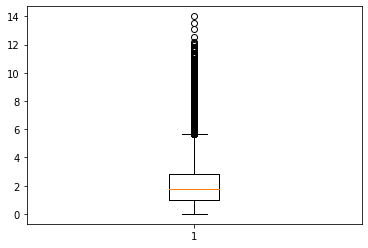

In [25]:
plt.boxplot(df['wv (m/s)'])

Los puntos en ambos diagramas representan los valores NO esperados en el conjunto de datos y es responsabilidad de cada ingeniero de datos decidir si dejarlos para el entrenamiento del modelo o no.

#Ingeniería de características

Antes de mandar los datos a un modelo, hay que corroborar si los datos que estamos enviando son los correctos y el sistema será capaz de interpretarlos correctamente. Para el caso de la columna dirección del viento (wd (deg)) los datos los tenemos en grados y es probable que el sistema no entienda que 0° y 360° son lo mismo, y puede que infiera que es mas grande 360° que 0° porque no tiene presente el contexto como nosotros los humanos. 

Para evitar este tipo de inconvenientes es necesario adaptar y desmenuzar en este caso contamos con la velocidad del viento, partiendo de la velocidad y ángulo podremos descomponer el sistema en vectores "x" y "y" para que la interpretación de los datos sea más entendible, además intrisecamente hace que la dirección del viento no importe si la velocidad del mismo es de 0. Para visualizar esto usaremos un histograma en 2D.

##Visualización de datos

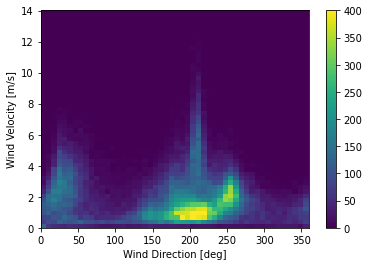

In [26]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
plt.show()

Conversion


In [27]:
#Eliminamos las columnas del dataframe y las guardamos en una variable en el caso de los ángulos los convertimos a redianes
wv = df['wv (m/s)']
max_wv = df.pop('max. wv (m/s)')
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculamos las componentes y guardamos en el dataframe
df['wx'] = wv*np.cos(wd_rad)
df['wy'] = wv*np.sin(wd_rad)

# Calculamos los valores máximos y mínimos y sus componentes
df['max wx'] = max_wv*np.cos(wd_rad)
df['max wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

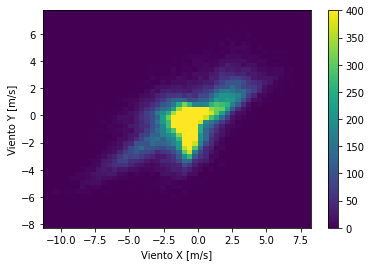

In [28]:
plt.hist2d(df['wx'], df['wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Viento X [m/s]')
plt.ylabel('Viento Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Ahora observamos como los datos están mejor agrupados y de esta manera será mas entendible para nuestro modelo.

#Análisis temporal

##Descomposición de una serie temporal

Una serie temporal se puede describir como la combinación de varios componentes 

*   Tendencia
*   Estacionalidad
*   Ruido
*   Nivel

Para describir la serie temporal, existen 2 modelos, multiplicativo y aditivo:

y(t) = Level + Trend + Seasonality + Noise

y(t) = Level * Trend * Seasonality * Noise

Para este ejemplo usaremos la velocidad del viento, que de antemano sabemos que es un fenómeno no estacionario, así que no se espera tener gráficos bonitos pero servirán para programar.



Visualizamos los datos

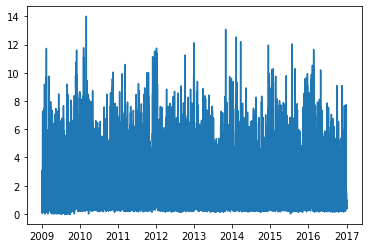

In [29]:
plt.plot(date_time, df[['wv (m/s)']])

usamos la funcion seasonal_decompose() para obterner cada elemento de la serie temporal usando:

modelo tipo aditivo

y como frecuencia observaremos el comportamiento anual (sabemos que los datos van por hora entonces el año= 24*365)

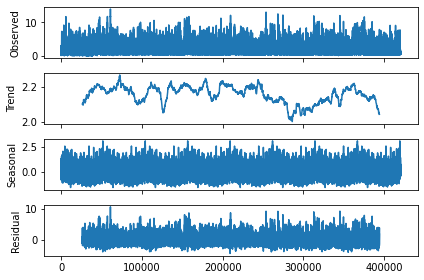

In [30]:
#Sabemos que la serie va por hora y queremos analizar un día entonces periodo=24
result=seasonal_decompose(df['wv (m/s)'], model='additive', freq=24*365)
result.plot()
plt.show()

In [31]:
print(result.trend[5000:-5000])
print(result.seasonal)
print(result.resid)

30005     2.115192
30011     2.115122
30017     2.115035
30023     2.115049
30029     2.115120
            ...   
390521    2.103485
390527    2.103271
390533    2.103027
390539    2.102809
390545    2.102639
Name: wv (m/s), Length: 60091, dtype: float64
5         0.006282
11       -0.147966
17       -0.133640
23       -0.276440
29       -0.083532
            ...   
420521    0.020787
420527   -0.116396
420533    0.350687
420539    0.296339
420545    0.737714
Name: wv (m/s), Length: 70091, dtype: float64
5        NaN
11       NaN
17       NaN
23       NaN
29       NaN
          ..
420521   NaN
420527   NaN
420533   NaN
420539   NaN
420545   NaN
Name: wv (m/s), Length: 70091, dtype: float64


Ahora veamos el contraste con otra variable No estacionaria: Temperatura;
a la que recordamos que ya habiamos hecho pruebas, sin embargo las gráficas se ven mucho mejor

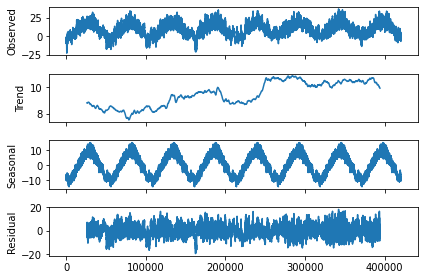

In [32]:
result=seasonal_decompose(df['T (degC)'], model='additive', freq=24*365)
result.plot()
plt.show()

##Conversión del tiempo a un espacio útil para el sistema.

###Fourier para determinar componentes temporales importantes

La transformada de fourier nos ayuda a determinar la frecuencia de aparición de ciertos eventos y la amplitud con la que suceden, viendolo de otro modo la importancia de eventos y su recurrencia.

Sabemos que un evento dependiente del tiempo es la temperatura, es por ello que vamos a analizar dicho componente.

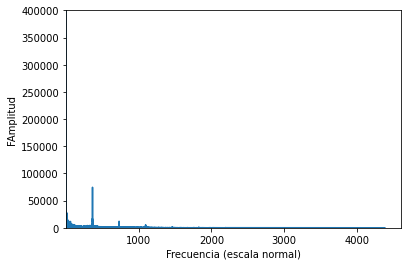

In [33]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
_ = plt.xlabel('Frecuencia (escala normal)')
_ = plt.ylabel('FAmplitud')



En el gráfico anterior observamos 2-4 picos interesantes, sin embargo por la escala es dificil interpretar de que se trata, por lo que cambiamos a escala logaritmica.

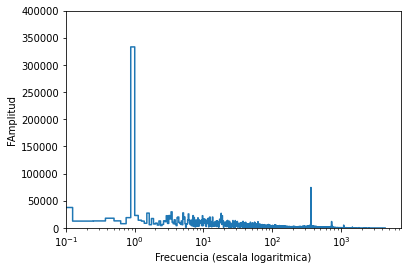

In [34]:
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
_ = plt.xlabel('Frecuencia (escala logaritmica)')
_ = plt.ylabel('FAmplitud')



Observamos que el primer pico ocurre en 10**0=1, como nuestra escala es a años tenemos que 1/10**0= 1 año.

Para encontrar la temporalidad en que ocurre el siguiente pico debemos encontrar donde se ubica, observamos que está arriba de 50000, por lo que buscaremos todos los picos y su correspondiente frecuencia arriba de ese valor

In [35]:
for x,y in zip(f_per_year, np.abs(fft)):
  if y>50000:
    print(x)


0.0
1.0005344594883794
365.1950777132585
365.32014452069456


Copmo curiosidad el primer elemento no se toma en cuenta porque siempre tiende a inf.

Observamos que las siguientes picos corresponden al día, recordando que un año tiene 365.2524.

Tomaremos como ejemplo el último valor:

365.32014452069456

tiempo= 1 año/365.32014452069456 

tiempo= 1año/365.32014452069456 * 365.2524 dias/1año =

tiempo = .9998 días

Redondeando tenemos que el otro punto de interes con mayor amplitud ocurre cada día.

In [36]:
t=(1/365.32014452069456)*365.2524
print(t)

0.9998145612233253


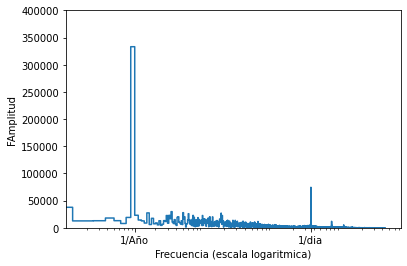

In [37]:
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.32014452069456], labels=['1/Año', '1/dia'])
_ = plt.xlabel('Frecuencia (escala logaritmica)')
_ = plt.ylabel('FAmplitud')

Y es lógico que la temperatura cambien en funcion del año (debido a la distancia de la tierra con el sol) y al día debido a la roteación de la misma

###Conversión de tiempo a un espacion Senoidal

Ya sabemos que lo que tiene mayor impacto es el año y el día, pero ¿cómo podemos transformar esos datos en algo útil apra el sistema?, la respuesta más sencilla es transfomar la fecha en señale senoidales y cosenoidales.

Para ello primero convertimos la fecha en segundos.



In [38]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Psoteriormente transformamos los segundos a señales seno y coseno

In [39]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Vamos a ver el comportamiento de la señales por día

Text(0.5, 1.0, 'Time of day signal')

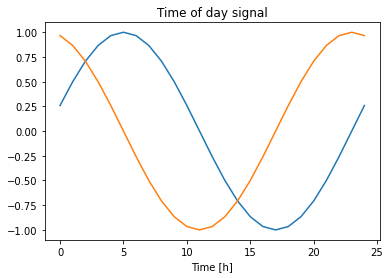

In [40]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Esto le da al modelo acceso a las características de frecuencia más importantes.

#Dividir los datos (entrenamiento, validación y pruebas) (70,20,10)

In [45]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

#Normalizar lso datos

Es importante acotar los datos en un espacion normalizado (-1-1)
Para ello se obtendrá el promedio del conjunto de entrenamiento y su respectiva desviación estandar lo cual nos permitirá acotar toda la información  centrada en 0 y con una desviacion estandar de 1

In [46]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

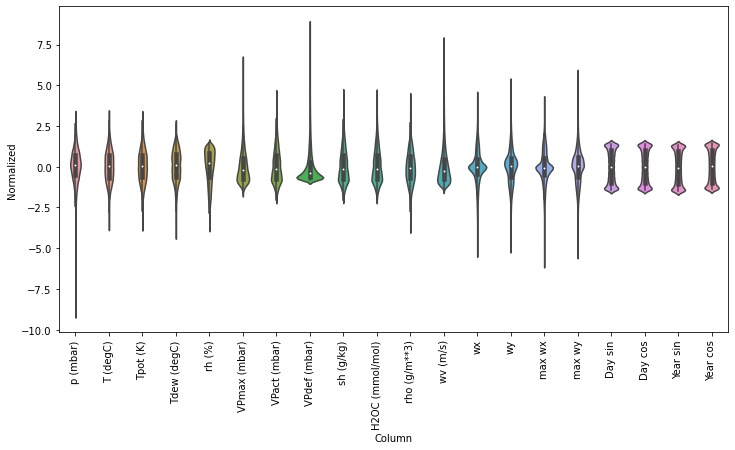

In [47]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

#Ventana de datos

Gneralmente en series de tiempo se realizan predicciones basadas en una ventana de muestras consecutivas de los datos.


Las principales características de las ventanas de entrada son:

*   El ancho (número de pasos de tiempo) de las ventanas de entrada y etiqueta.
*   El tiempo de compensación entre ellos.
*   Qué características se utilizan como entradas, etiquetas o ambas.



Dependiendo de la tarea y el tipo de modelo, es posible que desee generar una variedad de ventanas de datos. Aquí hay unos ejemplos:

Por ejemplo, para hacer una sola predicción 24 horas en el futuro, dadas las 24 horas de historial, puede definir una ventana como esta:

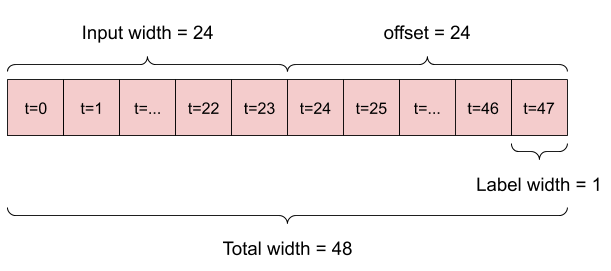

Una predicción de 24 horas en el futuro.


Un modelo que hace una predicción a una hora en el futuro, dadas seis horas de historia, necesitaría una ventana como esta:

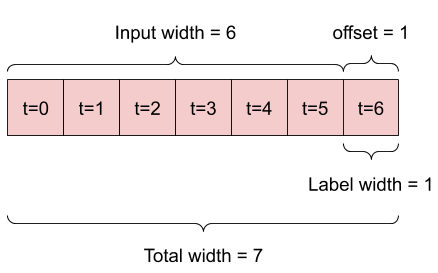

Una predicción de una hora en el futuro.



##FUNCION PARA GENERAR LAS VENTANAS

El resto de esta sección define una WindowGenerator clase. 

Esta clase puede:

Maneje los índices y compensaciones como se muestra en los diagramas de arriba.


Ventanas divididas de características en (features, labels) pares.


Trace el contenido de las ventanas resultantes.


Eficientemente generar lotes de estas ventanas de la formación, evaluación, y datos de ensayos, usando tf.data.Dataset s.

###Indices y Compensaciones

Generamos la clase WindowGenerator. 

El __init__ método incluye toda la lógica necesaria para los índices de entrada y de la etiqueta.


También toma los DataFrames de entrenamiento, evaluación y prueba como entrada. Estos se convertirán en tf.data.Dataset s de las ventanas más tarde.

In [49]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.label_columns = label_columns

    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

 
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Hagamos los ejemplos mostrados arriba

In [50]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [51]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

###Dividir los datos

Dada una lista de entradas consecutivas, el split_window método los convertirá en una ventana de entradas y una ventana de etiquetas.


El ejemplo w2 se define anteriormente se dividirá así:


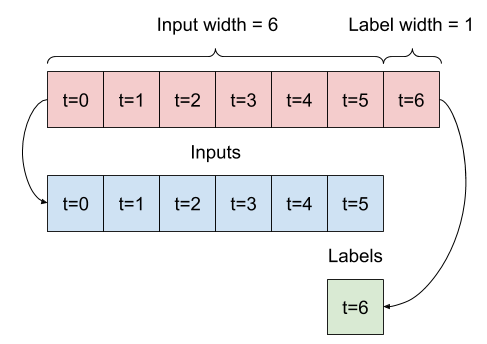

Este diagrama no muestra las features eje de los datos, pero esto split_window función también se encarga de las label_columns para que pueda ser usado para los ejemplos tanto la única salida y multi-salida.

In [52]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)


  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [53]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 20)
Inputs shape: (3, 6, 20)
Labels shape: (3, 1, 1)


Por lo general, los datos en TensorFlow se empaquetan en arreglos donde el primer índice es la dimensión "lote". Los índices intermedios son las dimensiones de "tiempo" o "espacio" (ancho, alto). el último índices  son las características.


El código anterior tomó un lote de tres ventanas de 7 pasos con 20 características en cada paso de tiempo. Los divide en un lote de entradas de 20 funciones de paso de 6 veces y una etiqueta de función de paso 1 de 1 vez. La etiqueta sólo tiene una característica porque el WindowGenerator se inicializa con label_columns=['T (degC)'] . 

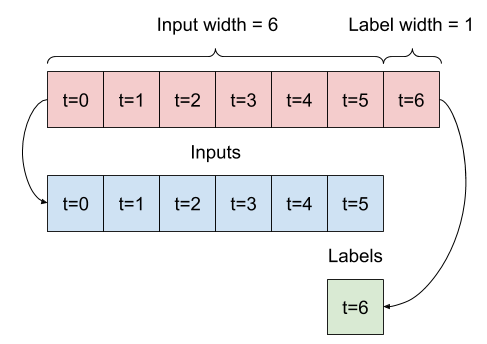

### Visualizar los datos

In [54]:
w2.example = example_inputs, example_labels

In [55]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

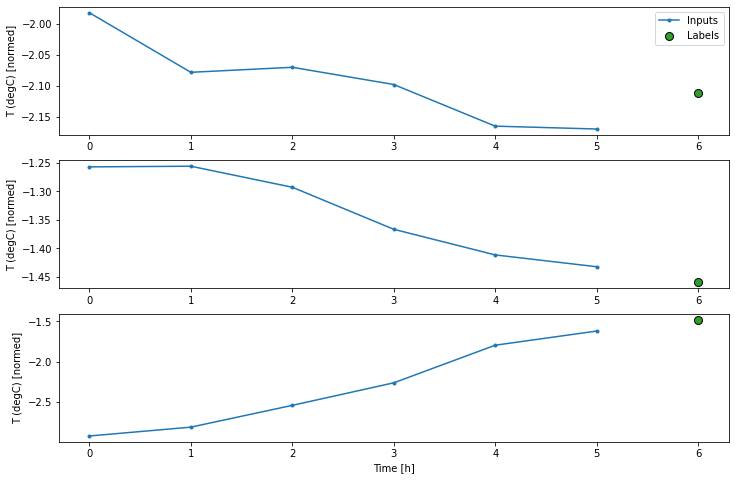

In [56]:
w2.plot()

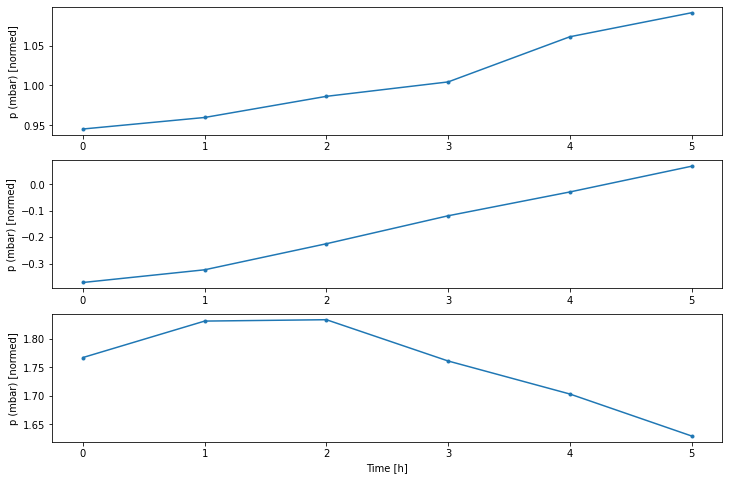

In [57]:
w2.plot(plot_col='p (mbar)')

### Creación de la base de datos

Por último, la clase make_dataset es un método que llevará a una serie  de datos y convertirlo a un tf.data.Dataset de (input_window, label_window) pares utilizando el preprocessing.timeseries_dataset_from_array función:

In [58]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

El WindowGenerator objeto contiene el entrenamiento, validación y los datos de prueba.

Se Añadieron propiedades para acceder a ellos como tf.data.Dataset's utilizando el make_dataset método definido previamente. Además, se agregó un lote de ejemplo estándar para facilitar el acceso y el trazado:

In [59]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Ahora, el WindowGenerator objeto le da acceso a la tf.data.Dataset objetos, por lo que fácilmente puede iterar sobre los datos.


El Dataset.element_spec propiedad que le dice a la estructura, tipos de datos, y las formas de los elementos del conjunto de datos.

In [60]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 20), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [63]:
for example_inputs, example_labels in w2.val.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 20)
Labels shape (batch, time, features): (32, 1, 1)
